# Building an Autoencoder with Haiku and JAX

*Prof Christopher Tunnell, 20-May-2024, HSF-India, U. Delhi*

This tutorial will guide you through the process of building an autoencoder using Haiku and JAX. The tutorial is designed for physics PhD students who may not have a deep understanding of programming or machine learning.

## Step 1: Install and import Necessary Libraries

These are pre-installed for this demo - but you can see them in the `requirements.txt` file that is next to this file.

### Concept:
We will use JAX for high-performance numerical computing, Haiku for building neural networks, Optax for optimization, and other supporting libraries.  (These should be installed.)

In [2]:
import haiku as hk

import jax
import jax.numpy as jnp
from jax import random

import optax

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

### Explanation:
1. **Import Haiku (hk)**:
    - Haiku is a neural network library developed by DeepMind.
    - It allows for easy construction of neural network modules with a functional approach.
    - Commonly used to define and train neural network architectures in a flexible and composable way.

2. **Import JAX**:
    - JAX is a library for high-performance numerical computing.
    - It provides automatic differentiation, GPU/TPU support, and a functional programming model.
    - Ideal for machine learning research and large-scale numerical experiments.

3. **Import JAX's numpy module (jnp)**:
    - `jax.numpy` (aliased as `jnp`) provides a NumPy-compatible interface.
    - Allows for operations on tensors with support for JAX's just-in-time compilation and automatic differentiation.

4. **Import random module from JAX**:
    - Provides functions for generating random numbers and manipulating random states.
    - Essential for initializing neural network weights and other stochastic processes in models.

5. **Import Optax**:
    - Optax is a gradient processing and optimization library for JAX.
    - It offers a variety of optimization algorithms (like Adam, SGD) for training neural networks.
    - Facilitates the implementation of complex training loops and gradient updates.

6. **Import load_digits from sklearn.datasets**:
    - `load_digits` is a utility function to load the digits dataset, a popular toy dataset in machine learning.
    - Useful for testing algorithms and prototyping models.

7. **Import train_test_split from sklearn.model_selection**:
    - `train_test_split` is used to split data into training and testing sets.
    - Helps evaluate the performance of machine learning models on unseen data.

8. **Import tqdm notebook**:
    - `tqdm` provides a fast, extensible progress bar for loops.
    - The `notebook` variant integrates seamlessly with Jupyter Notebooks, providing a visual progress bar for iterative processes.

9. **Import matplotlib.pyplot as plt**:
    - `matplotlib.pyplot` is a plotting library for creating static, animated, and interactive visualizations in Python.
    - Essential for visualizing data, model performance, and other results in scientific research.

## Step 2: Define the Autoencoder Model

An autoencoder is a type of neural network used to learn efficient representations of data, typically for the purpose of dimensionality reduction (incl. compression), feature learning, or anomaly detection. It consists of two main parts: the encoder and the decoder.  The input and output of the autoencoder are the same.

![Autoencoder drawing](https://uvadlc-notebooks.readthedocs.io/en/latest/_images/autoencoder_visualization.svg)

### Concept:
The encoder compresses the input data into a smaller, latent space representation, and the decoder reconstructs the original data from this compressed representation.  The encoder compresses the input data into a lower-dimensional latent space representation, while the decoder reconstructs the input data from this compact representation.

In particle physics, autoencoders can be particularly useful for anomaly detection in high-dimensional data, such as identifying rare events in large datasets from particle collisions. For instance, in a dataset of events recorded from a particle detector at the Large Hadron Collider, an autoencoder can be trained on known background events. When presented with new data, events that are poorly reconstructed by the autoencoder may indicate the presence of novel or rare physical phenomena, such as potential signals for new particles or interactions beyond the Standard Model.

Learn more about [Autoencoders on Wikipedia](https://en.wikipedia.org/wiki/Autoencoder).

In [3]:
class Autoencoder(hk.Module):
    def __init__(self, encoder_layers, decoder_layers):
        super().__init__()
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers

    def __call__(self, x):
        # Encoder
        for units in self.encoder_layers:
            x = hk.Linear(units)(x)
            x = jax.nn.tanh(x)

        # Latent space
        latent = x

        # Decoder
        for units in self.decoder_layers[:-1]:
            x = hk.Linear(units)(x)
            x = jax.nn.tanh(x)

        # Output layer
        x = hk.Linear(self.decoder_layers[-1])(x)
        return x, latent

### Explanation:
1. **Encoder**:
    - The encoder compresses the input data into a latent space.
    - Each layer in the encoder is a dense layer followed by a tanh activation function.

2. **Latent Space**:
    - The compressed representation of the input data.

3. **Decoder**:
    - The decoder reconstructs the data from the latent space.
    - Each layer in the decoder is a dense layer followed by a tanh activation function.
    - The final layer outputs the reconstructed data.

## Step 3: Create a Train State

To train the neural network, we need to manage the model parameters and the optimizer state. This step involves creating a training state that includes these components.

### Concept:
We initialize the model parameters and set up the optimizer, which will update the model parameters during training to minimize the loss function.

Learn more about [Optimization in Machine Learning on Wikipedia](https://en.wikipedia.org/wiki/Optimization_(mathematics)).

In [4]:
def create_train_state(rng, model, learning_rate, input_shape):
    params = model.init(rng, jnp.ones(input_shape))
    tx = optax.adam(learning_rate)
    opt_state = tx.init(params)
    return params, opt_state, tx

### Explanation:
1. **Model Initialization**:
    - We initialize the model parameters using a random key (`rng`) and a dummy input.

2. **Optimizer**:
    - We use the Adam optimizer with a specified learning rate.
    - The optimizer state is initialized using the model parameters.

## Step 4: Define the Loss Function and Update Step

To train the autoencoder, we need a loss function that measures the difference between the original and reconstructed data. Additionally, we define an update step to adjust the model parameters based on this loss.

### Concept:
The loss function helps us quantify how well the autoencoder is performing, and the update step involves using gradient descent to minimize this loss.

Learn more about [Loss Functions on Wikipedia](https://en.wikipedia.org/wiki/Loss_function).

In [5]:
def compute_loss(params, rng, batch):
    preds, _ = model.apply(params, rng, batch)
    loss = jnp.mean((preds - batch) ** 2)
    return loss

@jax.jit
def update(params, opt_state, rng, batch):
    rng, new_rng = random.split(rng)
    loss, grads = jax.value_and_grad(compute_loss)(params, rng, batch)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, new_rng

### Explanation:
1. **Loss Function**:
    - The `compute_loss` function calculates the mean squared error between the predicted and actual data.

2. **Update Step**:
    - The `update` function calculates the gradients of the loss with respect to the model parameters.
    - The optimizer updates the model parameters using the gradients.

## Step 5: Prepare the Data

We will use the Digits dataset from scikit-learn for training the autoencoder. The data is scaled to have zero mean and unit variance.

### Concept:
Data preprocessing is crucial for machine learning as it ensures that the data is in a suitable format and scale for the model to learn effectively.

Learn more about the [Digits Dataset on Wikipedia](https://en.wikipedia.org/wiki/Optical_character_recognition).

In [6]:
# Load and scale the data
digits = load_digits()
data = digits.data

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

### Explanation:
1. **Loading the Data**:
    - We load the Digits dataset using scikit-learn.

2. **Splitting the Data**:
    - We split the data into training and testing sets.
    
## Visualize the data

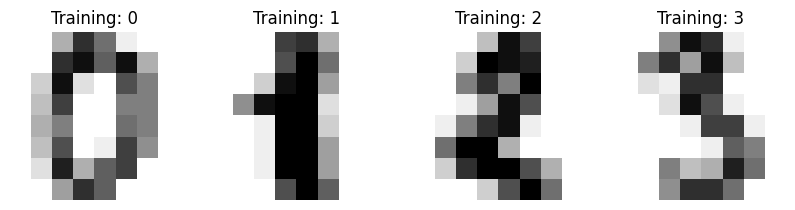

In [7]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image,
              cmap=plt.cm.gray_r,
              interpolation="nearest",
              vmin=0, vmax=16)
    ax.set_title("Training: %i" % label)

This data is the input into the autoencoder and will be compared to the output.

## Step 6: Train the Autoencoder

We will train the autoencoder using the training data and evaluate it using the test data.

### Concept:
Training involves feeding the data through the autoencoder, computing the loss, and updating the model parameters to minimize this loss. We also evaluate the model on test data to monitor its performance.

Learn more about [Backpropagation on Wikipedia](https://en.wikipedia.org/wiki/Backpropagation).

In [8]:
# Initialize model and training state
rng = random.PRNGKey(0)
model = hk.transform(lambda x: Autoencoder([128, 64, 64, 64], [64, 64, 64, 128, data.shape[1]])(x))
params, opt_state, tx = create_train_state(rng, model, learning_rate=0.001, input_shape=(data.shape[1],))

# Training loop
num_epochs = 1000
batch_size = 32
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    for i in range(0, len(train_data), batch_size):
        batch = train_data[i:i + batch_size]
        params, opt_state, train_loss, rng = update(params, opt_state, rng, batch)

    rng, new_rng = random.split(rng)
    test_loss = compute_loss(params, new_rng, test_data)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Explanation:
1. **Initialize Model and Training State**:
    - We create a random key `rng` and initialize the autoencoder model with specified encoder and decoder layers.  Often autoencoders perform better with more layers.
    - We create the initial training state using the `create_train_state` function.

2. **Training Loop**:
    - We specify the number of epochs (`num_epochs`) and batch size (`batch_size`).
    - We initialize lists to store the training and validation losses.

3. **Epoch Loop**:
    - We use `tqdm` to create a progress bar for the training loop.
    - For each epoch, we iterate over the training data in batches, updating the model parameters using the `update` function.
    - After processing all batches in an epoch, we compute the validation loss using `compute_loss` and store the losses.

## Step 7: Plot the Training and Validation Losses

After training the autoencoder, we can visualize the training and validation losses over epochs to understand how well the model is learning.

### Concept:
Plotting the losses helps us monitor the training process and detect issues like overfitting, where the model performs well on training data but poorly on test data.

Learn more about [Loss Functions and Training on Wikipedia](https://en.wikipedia.org/wiki/Loss_function).

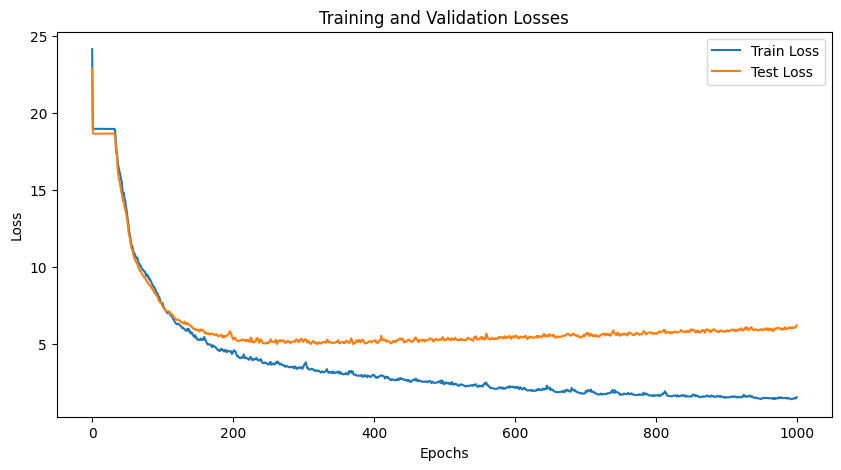

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
#plt.yscale('log')
plt.show()

### Explanation:
1. **Plotting**:
    - We use Matplotlib to create a plot of the training and validation losses over epochs.
    - We label the x-axis as 'Epochs' and the y-axis as 'Loss'.
    - We add a legend to distinguish between training and validation losses.
    - We set the title of the plot to 'Training and Validation Losses'.
    - Finally, we displayed the plot.

### Question:

Why does the training loss improve whereas the test loss does not?  What does this indicate about the number of epochs that you are training or the complexity of your network?  Please fix.
    
## Step 8: Check the prediction

We can compare the image input and output.

### Concept:
If the network has learned what a number looks like, then the input and outputs should look similar.

Learn more about [XX on Wikipedia](https://en.wikipedia.org/wiki/XX).

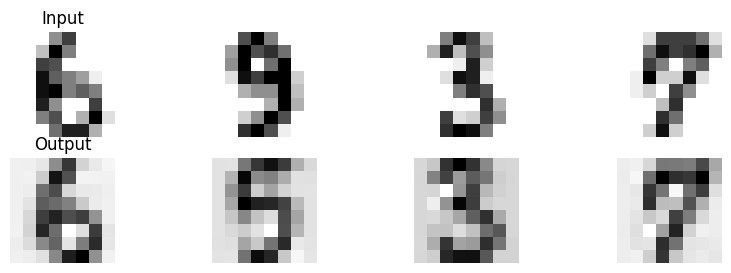

In [10]:
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 3))
predicted_data, _ = model.apply(params, rng, test_data)
for i in range(4):
    axes[0][i].set_axis_off()
    axes[0][i].imshow(test_data[i].reshape(8, 8),
                      cmap=plt.cm.gray_r, interpolation="nearest")
    
    axes[1][i].set_axis_off()
    axes[1][i].imshow(predicted_data[i].reshape(8, 8),
                      cmap=plt.cm.gray_r, interpolation="nearest")
axes[0][0].set_title('Input')
_= axes[1][0].set_title('Output')

### Explanation:
 1. The input and resulting output look somewhat similar.

### Question:

 - How can you quantify this difference?  Have we already done this?  If so, how? 
    
## Step 9: Anomaly detection

When the autoencoder fails to accurately reconstruct a given input, it signifies a deviation from the patterns learned during training. This discrepancy can be quantified by the reconstruction error, which measures the difference between the input and its reconstruction. 

### Concept:
In particle physics, a high reconstruction error suggests that the event does not conform to the known background and might be indicative of new physics. By setting a threshold on the reconstruction error, physicists can flag potential anomalies for further investigation, thus aiding in the discovery of rare and novel events in particle collision data.

Learn more about [Anomaly Detection on Wikipedia](https://en.wikipedia.org/wiki/Anomaly_detection).

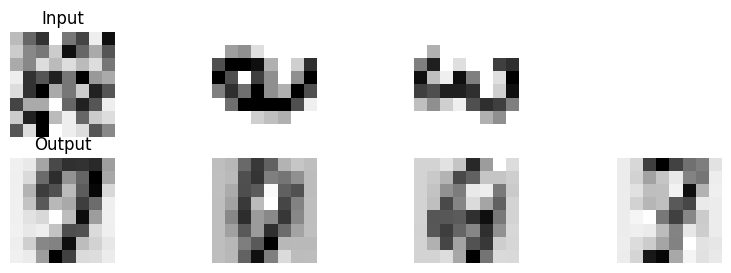

In [190]:
# Corrupted data with anomalies
bad_data = test_data.copy()
bad_data[0] = jax.random.randint(rng, shape=(64,), minval=0, maxval=16)
bad_data[1] = bad_data[1].reshape(8, 8).T.reshape(64)
bad_data[2] = bad_data[2].reshape(8, 8).T.reshape(64)
bad_data[3] = 16 * jnp.ones(64)

# Plotting like before
_, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 3))
predicted_bad_data, _ = model.apply(params, rng, bad_data)
for i in range(4):
    axes[0][i].set_axis_off()
    axes[0][i].imshow(bad_data[i].reshape(8, 8),
                      cmap=plt.cm.gray_r, interpolation="nearest")
    
    axes[1][i].set_axis_off()
    axes[1][i].imshow(predicted_bad_data[i].reshape(8, 8),
                      cmap=plt.cm.gray_r, interpolation="nearest")
axes[0][0].set_title('Input')
_= axes[1][0].set_title('Output')

# Print the loss for the anomalous data
print(f'The loss is: {compute_loss(params, new_rng, bad_data)}')

### Explanation:
 1. *Creating anomalies:*  We create a dataset `bad_data` consisting of corrupted data.
 2. *Plotting:* We see that the neural network is unable to make accurate predictions with this data, indicating that it has not seen similar data before.
 3. *Compute loss for anomalous data:* We compute the loss for the anomalous data, which is a high value indiciating anomaly.

### Question:

 - How does this loss compare to the loss that you expect from the training or test datasets?  Please add a horizontal line to the loss v.s. epoch plot above with the loss we just calculated.
 - What threshold would you set for a loss function to be anomalous?  How often does 'good' data fail this criterion?
 
### Exercise:

 - (Hard) Adjust the code above to use the H->WW example that we used in the other tutorial.  You can use the following hint:

In [ ]:
#from extra_functions import load_training_file
#all_data = load_training_file()
#df = all_data.loc[:, ("met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1')]
#del all_data['index']
#del all_data['eventNumber']
#del all_data['mcWeight']
#del all_data['channelNumber']
#all_data.head()

## End